<a href="https://colab.research.google.com/github/ALejandroCh17/Tennis-Ball-Robot/blob/daniel_branch/rally_rover_tennis_ball_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tennis Ball Image Binary Classification

In [107]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing modules

In [108]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
import os
import random
from hashlib import sha256

## Exploratory Data Analysis

In [109]:
# Define the paths to the folders containing the images
folders = [
    '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/train/balls',
    '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/train/empty',
    '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/balls',
    '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/empty'
]

**Sample Image Display**

In [110]:
# Gather all image paths from the folders
all_image_paths = []
for folder in folders:
    for image_name in os.listdir(folder):
        all_image_paths.append(os.path.join(folder, image_name))

In [111]:
# Select 5 random images from the entire dataset
selected_image_paths = random.sample(all_image_paths, 5)

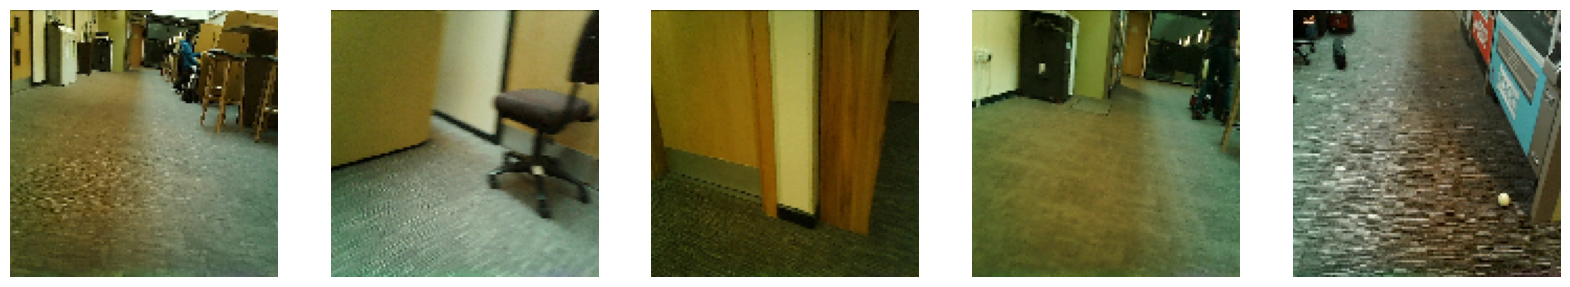

In [112]:
# Plot the selected images
plt.figure(figsize=(20, 4))
for i, img_path in enumerate(selected_image_paths):
    img = load_img(img_path, color_mode='rgb', target_size=(128, 128))  # Load and resize the image
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

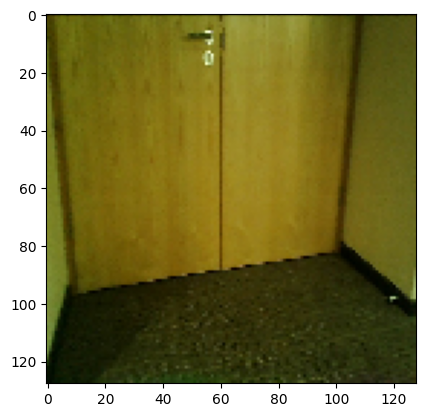

In [113]:
# Showing no ball image
img = load_img('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/empty/empty517.jpg', color_mode='rgb', target_size=(128,128))
img_arr = img_to_array(img)
plt.imshow(img)

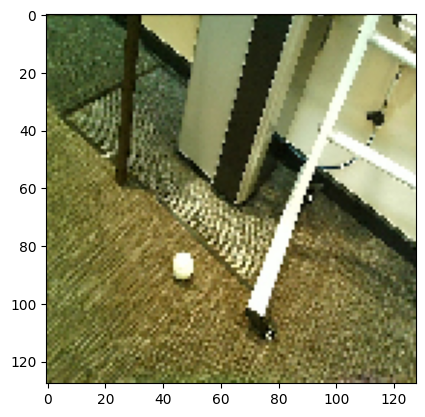

In [114]:
# Showing ball image
img = load_img('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/balls/ball97.jpg', color_mode='rgb', target_size=(128,128))
img_arr = img_to_array(img)
plt.imshow(img)

A comparison between both image confirms our expectation of a ball either present or not present.

In [115]:
# Converts images to arrays for processing.
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = load_img(os.path.join(folder,filename), color_mode='rgb', target_size=(128, 128))
        img_arr = img_to_array(img)
        images.append(img_arr)
    return images

**Label Distribution**

In [116]:
# Converting training sets to num arrays
x_train_balls = load_images_from_folder('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/train/balls')
x_train_empty = load_images_from_folder('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/train/empty')
x_test_balls = load_images_from_folder('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/balls')
x_test_empty = load_images_from_folder('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/empty')

In [117]:
# Set the directory for each class
dir_train_balls = '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/train/balls'
dir_train_empty = '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/train/empty'
dir_test_balls = '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/balls'
dir_test_empty = '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/empty'

# Count the number of images in each directory
count_train_balls = len(os.listdir(dir_train_balls))
count_train_empty = len(os.listdir(dir_train_empty))
count_test_balls = len(os.listdir(dir_test_balls))
count_test_empty = len(os.listdir(dir_test_empty))

total_balls = count_train_balls + count_test_balls
total_empty = count_train_empty + count_test_empty

print(f'Balls: {total_balls}')
print(f'Empty: {total_empty}')

Balls: 446
Empty: 446


There are equal number of both types of images after modifying google drive file.

## Data Preprocessing

**Removing Duplicates**

In [118]:
# Concatenating no-ball and yes-ball sets together
y_train = np.concatenate( ( np.ones(len(x_train_balls)), np.zeros(len(x_train_empty))) )
x_train = np.concatenate( (np.array(x_train_balls), np.array(x_train_empty) ) )
y_test = np.concatenate( (np.ones(len(x_test_balls)), np.zeros(len(x_test_empty))) )
x_test = np.concatenate( (np.array(x_test_balls), np.array(x_test_empty) ) )

In [119]:
# Combine the datasets
x_combined = np.concatenate((x_train, x_test))
y_combined = np.concatenate((y_train, y_test))

In [120]:
print(f'Total: {len(x_combined)}')

Total: 892


892 total images in dataset before removing duplicates

In [121]:
# Flatten the image data
flattened_images = [image.flatten() for image in x_combined]

# Hash the flattened data
hashes = [sha256(image.data.tobytes()).hexdigest() for image in flattened_images]

# Identify and remove duplicates
unique_hashes = set()
unique_images = []

for i, hash_val in enumerate(hashes):
    if hash_val not in unique_hashes:
        unique_hashes.add(hash_val)
        unique_images.append(x_combined[i])

# unique_images now contains only unique images
x_combined = np.array(unique_images)

In [122]:
print(f'Total: {len(x_combined)}')

Total: 892


Data already had all unique images

## Data Split

In [123]:
# Shuffle the combined dataset
randomize_combined = np.arange(len(y_combined))
np.random.shuffle(randomize_combined)
x_combined = x_combined[randomize_combined]
y_combined = y_combined[randomize_combined]

In [124]:
# New Split
x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(x_combined, y_combined, test_size=0.30, random_state=42)

# Normalize the pixel values if you haven't done it before
x_train_new = x_train_new / 255
x_test_new = x_test_new / 255

In [125]:
# Display the shapes of the resulting datasets
print("X_train shape:", x_train_new.shape)
print("X_test shape:", x_test_new.shape)
print("y_train shape:", y_train_new.shape)
print("y_test shape:", y_test_new.shape)

X_train shape: (624, 128, 128, 3)
X_test shape: (268, 128, 128, 3)
y_train shape: (624,)
y_test shape: (268,)


In [126]:
x_train_new[400:405]

array([[[[0.48235294, 0.5019608 , 0.2509804 ],
         [0.45882353, 0.47843137, 0.21960784],
         [0.43529412, 0.4509804 , 0.21176471],
         ...,
         [0.32156864, 0.24705882, 0.        ],
         [0.34901962, 0.2627451 , 0.02745098],
         [0.36078432, 0.2901961 , 0.03921569]],

        [[0.6745098 , 0.7176471 , 0.34117648],
         [0.68235296, 0.72156864, 0.34117648],
         [0.6901961 , 0.7176471 , 0.3529412 ],
         ...,
         [0.53333336, 0.47058824, 0.09411765],
         [0.57254905, 0.49803922, 0.13725491],
         [0.5294118 , 0.4627451 , 0.10196079]],

        [[0.6666667 , 0.7176471 , 0.35686275],
         [0.6745098 , 0.70980394, 0.34509805],
         [0.6901961 , 0.7137255 , 0.36862746],
         ...,
         [0.5411765 , 0.47843137, 0.10588235],
         [0.54509807, 0.47843137, 0.11764706],
         [0.54509807, 0.48235294, 0.10980392]],

        ...,

        [[0.09019608, 0.11372549, 0.00392157],
         [0.09803922, 0.11764706, 0.        ]

In [127]:
y_train_new[400:405]

array([1., 1., 0., 0., 1.])

## Model Development

In [128]:
model = Sequential()

model.add(Conv2D(16, kernel_size=3, activation='relu', input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=20, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=5, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])

## Training model

In [139]:
model.fit(x=x_train_new, y=y_train_new, validation_data=(x_test_new, y_test_new), epochs=10)

Epoch 1/10
20/20 [==============================] - 1s 24ms/step - loss: 0.5457 - accuracy: 0.7276 - val_loss: 0.5380 - val_accuracy: 0.7425
Epoch 2/10
20/20 [==============================] - 0s 11ms/step - loss: 0.5463 - accuracy: 0.7420 - val_loss: 0.6570 - val_accuracy: 0.6530
Epoch 3/10
20/20 [==============================] - 0s 11ms/step - loss: 0.5247 - accuracy: 0.7612 - val_loss: 0.5332 - val_accuracy: 0.7687
Epoch 4/10
20/20 [==============================] - 0s 11ms/step - loss: 0.4894 - accuracy: 0.7885 - val_loss: 0.4996 - val_accuracy: 0.7687
Epoch 5/10
20/20 [==============================] - 0s 10ms/step - loss: 0.4984 - accuracy: 0.7788 - val_loss: 0.5105 - val_accuracy: 0.7687
Epoch 6/10
20/20 [==============================] - 0s 10ms/step - loss: 0.4567 - accuracy: 0.7933 - val_loss: 0.5080 - val_accuracy: 0.7537
Epoch 7/10
20/20 [==============================] - 0s 10ms/step - loss: 0.4453 - accuracy: 0.8141 - val_loss: 0.5143 - val_accuracy: 0.7463
Epoch 8/10
20

## History

In [130]:
history = pd.DataFrame(model.history.history)
model_loss = history.drop(columns=['accuracy', 'val_accuracy'])
model_accuracy = history.drop(columns=['loss', 'val_loss'])

<Axes: >

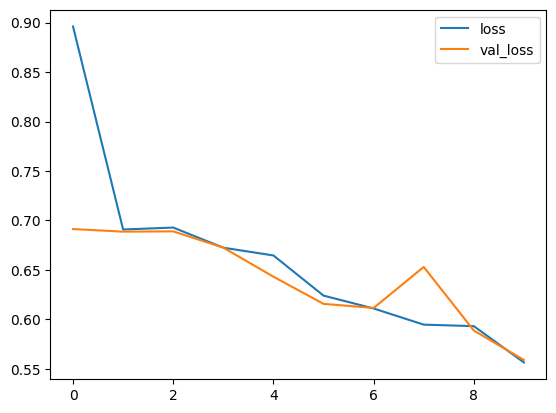

In [131]:
model_loss.plot()

<Axes: >

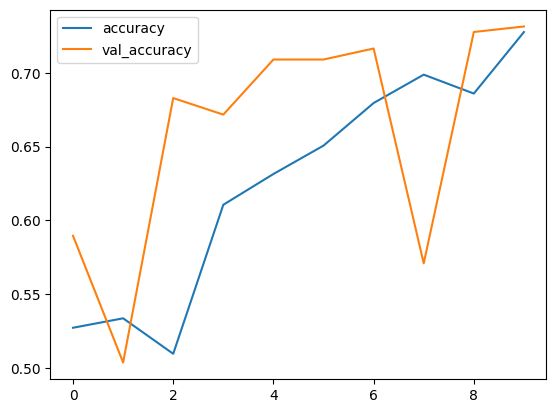

In [132]:
model_accuracy.plot()

## Model evaluation

In [133]:
predictions = np.rint(model.predict(x_test))

3/3 [==============================] - 0s 4ms/step


In [134]:
print( classification_report(y_test, predictions) )

              precision    recall  f1-score   support

         0.0       0.69      0.83      0.75        29
         1.0       0.85      0.72      0.78        40

    accuracy                           0.77        69
   macro avg       0.77      0.78      0.77        69
weighted avg       0.78      0.77      0.77        69



In [135]:
confusion_matrix(y_test, predictions)

array([[24,  5],
       [11, 29]])

Text(0.5, 1.0, 'prediction: [0.]')

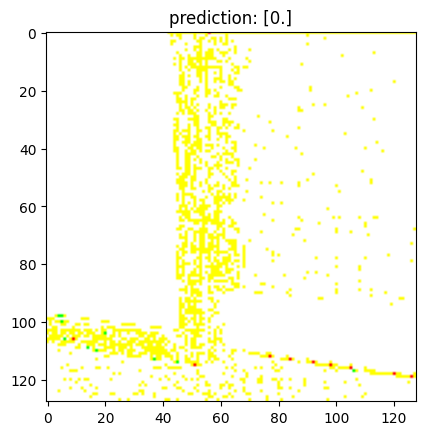

In [136]:
sample = 43
plt.imshow(x_test[sample], cmap=plt.cm.gray_r)
plt.title('prediction: ' + str(predictions[sample]) )

## Save model

In [137]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Load model

In [138]:
model = tf.keras.models.load_model('model.h5')